In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
groundTruth_Users = os.listdir("groundTruth")
MyoData_Users = os.listdir("MyoData")

In [4]:
user_id = []
for i in range(len(MyoData_Users)):
    if MyoData_Users[i] in groundTruth_Users:
        user_id.append(MyoData_Users[i])
        
directory_clean_data = "clean_data/"
if not os.path.exists(directory_clean_data):
        os.makedirs(directory_clean_data)

In [5]:
def get_paths(user, fork_or_spoon= 'fork'):
    parent_path = "MyoData/" + user + '/' + fork_or_spoon
    dir_list = os.listdir(parent_path)
    EMG_txt_path = parent_path + "/" + dir_list[0]
    IMU_txt_path = parent_path + "/" + dir_list[1]
    video_info_path = parent_path + "/" + dir_list[2]
    # get ground truth
    ground_truth_parent_path = "groundTruth/" + user + '/' + fork_or_spoon
    ground_truth_dir_list = os.listdir(ground_truth_parent_path)
    ground_truth_path = ground_truth_parent_path + "/" + ground_truth_dir_list[0]
    return (EMG_txt_path, IMU_txt_path, video_info_path, ground_truth_path)

def mul(x, y):
    try:
        return np.round(pd.to_numeric(x) * y)
    except:
        return x

def get_dataframe(user = "user10", data_for="EMG", fork_or_spoon="fork"):
    paths = get_paths(user, fork_or_spoon)
    if data_for == "EMG":
        df = pd.read_csv(paths[0], sep=",", header=None)
        df.columns = ['UNIX time stamp', 'EMG 1', 'EMG 2', 'EMG 3', 'EMG 4', 'EMG 5', 'EMG 6', 'EMG 7', 'EMG 8']
        return df.assign(eating=False)
    elif( data_for == "IMU"):
        df = pd.read_csv(paths[1], sep=",", header=None)
        df.columns = ['UNIX time stamp', 'Orientation X', 'Orientation Y', 'Orientation Z', 'Orientation W', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z', 'Gyroscope X', 'Gyroscope Y','Gyroscope Z'] 
        return df.assign(eating=False)
    elif( data_for == "ground_truth"):
        df = pd.read_csv(paths[3], sep=",", header=None)
        df.columns = ["start","stop", "noise"] 
        df.drop(['noise'],axis=1,inplace=True)
        return df.applymap(lambda x: mul(x, 100/30))
    else:
        df = pd.read_csv(paths[2], header=None)
        df.columns = ["starting frame", "ending frame"]
        return df
    
def save_clean_data(df_ground_truth, df, name, user, fork_or_spoon="fork"):
    for index, row in df_ground_truth.iterrows():
        eating_start = row[0] # note: maybe add one here. depends on if index at 0 or 1. I assumed 0
        eating_stop = row[1]
        df.loc[ eating_start:eating_stop , 'eating'] = True
    

    df_eating = df[df['eating'] == True]
    df_not_eating = df[df['eating'] == False]
    
    directory = "clean_data/" + user + "/" + fork_or_spoon
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    #df_eating.to_csv(sep=',', index=False, header=False)
    df_eating.reset_index(drop=True,inplace=True)
    df_not_eating.reset_index(drop=True,inplace=True)
    min_data_points = min(df_eating.shape[0], df_not_eating.shape[0])
    df_eating = df_eating.iloc[:min_data_points]
    df_not_eating = df_not_eating.iloc[:min_data_points]
    
    df_eating.to_csv(path_or_buf=directory+"/eating_" + name + ".txt", sep=',')
    df_not_eating.to_csv(path_or_buf=directory+"/not_eating_" + name + ".txt", sep=',')
    df.to_csv(path_or_buf=directory+"/master_df" + name + ".txt", sep=',')
    

In [6]:
def delete_dir_recursive(target):
    for d in os.listdir(target):
        try:
            delete_dir_recursive(target + '/' + d)
        except OSError:
            os.remove(target + '/' + d)

    os.rmdir(target)

def clean_data_for_each_user():
    delete_users = []
    for user in user_id:
        for fork_or_spoon in ['spoon','fork']:
            try:
                df_EMG = get_dataframe(user, data_for="EMG", fork_or_spoon=fork_or_spoon)
                df_IMU = get_dataframe(user, data_for="IMU", fork_or_spoon=fork_or_spoon)
                df_ground_truth = get_dataframe(user, data_for="ground_truth", fork_or_spoon=fork_or_spoon)

                save_clean_data(df_ground_truth, df_EMG, name="EMG", user=user, fork_or_spoon=fork_or_spoon)
                save_clean_data(df_ground_truth, df_IMU, name="IMU", user=user, fork_or_spoon=fork_or_spoon)
            except:
                print("error, data not in the same format as given in the original assignment for ---> " + user)
                print("removing from list of users to use in the project")
                delete_users.append(user)
                try:
                    target = "clean_data/" + user
                    delete_dir_recursive(target)
                    print("deleted directory for that user.")
                except:
                    print("no need to delete directory. It was not created.")
                break
                
    try:
        for user in delete_users:
            print("deleted " + user + " from user_id list so that it would not be used in Phase two and three")
            user_id.remove(user)
    except:
        print("error with deleting user from user_id list")

In [7]:
def get_clean_paths(user, fork_or_spoon= 'fork'):
    parent_path = "clean_data/" + user + '/' + fork_or_spoon
    #dir_list = os.listdir(parent_path)
    EMG_eating_txt_path = parent_path + "/" + "eating_EMG.txt"
    EMG_not_eating_txt_path = parent_path + "/" + "not_eating_EMG.txt"
    IMU_eating_txt_path = parent_path + "/" + "eating_IMU.txt"
    IMU_not_eating_txt_path = parent_path + "/" + "not_eating_IMU.txt"
    master_EMG_path = parent_path + "/" + "master_dfEMG.txt"
    master_IMU_path = parent_path + "/" + "master_dfIMU.txt"
    return (master_EMG_path, EMG_eating_txt_path, EMG_not_eating_txt_path, master_IMU_path, IMU_eating_txt_path, IMU_not_eating_txt_path)

def get_clean_df(user = "user10", data_for="EMG", fork_or_spoon="fork", eating=True, master=False):
    paths = get_clean_paths(user, fork_or_spoon)
    if data_for == "EMG":
        if master:
            return pd.read_csv(paths[0], sep=",", index_col=0)
        elif eating:
            return pd.read_csv(paths[1], sep=",", index_col=0)
        else:
            return pd.read_csv(paths[2], sep=",", index_col=0)

    elif( data_for == "IMU"):
        if master:
            return pd.read_csv(paths[3], sep=",", index_col=0)
        elif eating:
            return pd.read_csv(paths[4], sep=",", index_col=0)
        else:
            return pd.read_csv(paths[5], sep=",", index_col=0)
    

# RMS

In [8]:
# RMS_feature_extraction(df1,df2)
# RMS_feature_extraction(df1_IMU,df2_IMU)
def RMS_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False, item='fork'):
    if col_wise:
        axis = 0
        n = (df1.iloc[:,1:-1]).shape[0]
    else:
        axis = 1 
        n = (df1.iloc[:,1:-1]).shape[1]
    if get_feature_data:
        eating_feature_data = ((((df1.iloc[:,1:-1]**2).sum(axis))/n).pow(1/2))
        non_eating_feature_data = (((df2.iloc[:,1:-1]**2).sum(axis)/n).pow(1/2))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((((df1.iloc[:,1:-1]**2).sum(axis))/n).pow(1/2)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]**2).sum(axis)/n).pow(1/2).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.ylabel("EMG sensor level")
        plt.title("RMS for " + user + " " + item )
        plt.savefig('graphs/RMS' + user + item +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in RMS_feature_extraction()")

# avg

In [9]:
# AVG_feature_extraction(df1,df2)
# AVG_feature_extraction(df1_IMU,df2_IMU)
def AVG_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False, item='fork'):
    if col_wise:
        axis = 0
    else:
        axis = 1 
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).abs().mean(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).abs().mean(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).abs().mean(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).abs().mean(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("AVG for " + user + " " + item )
        plt.ylabel("EMG sensor level")
        plt.savefig('graphs/AVG' + user + item +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in AVG_feature_extraction()")

# min

In [10]:
# MIN_feature_extraction(df1,df2)
def MIN_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False, item='fork'):
    if col_wise:
        axis = 0
    else:
        axis = 1 
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).min(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).min(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).min(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).min(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.ylabel("EMG sensor level")
        plt.title("MIN for " + user + " " + item )
        plt.savefig('graphs/MIN' + user + item +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in MIN_feature_extraction()")

# max

In [11]:
# MAX_feature_extraction(df1,df2)
# MAX_feature_extraction(df1_IMU,df2_IMU)
def MAX_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False, item='fork'):
    if col_wise:
        axis = 0
    else:
        axis = 1 
        
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).abs().max(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).abs().max(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).abs().max(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).abs().max(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.title("MAX for " + user + " " + item )
        plt.ylabel("EMG sensor level")
        plt.savefig('graphs/MAX' + user + item +'.png' , bbox_inches='tight')
        plt.show()
    except:
        print("error in MAX_feature_extraction()")

# std

In [12]:
# STD_feature_extraction(df1,df2)
# STD_feature_extraction(df1_IMU,df2_IMU)
def STD_feature_extraction(df1,df2,col_wise=True,user="user10", get_feature_data=False, item='fork'):
    if col_wise:
        axis = 0
    else:
        axis = 1 
        
    if get_feature_data:
        eating_feature_data = ((df1.iloc[:,1:-1]).abs().std(axis))
        non_eating_feature_data = ((df2.iloc[:,1:-1]).abs().std(axis))
        return ( (pd.DataFrame(eating_feature_data)).T, (pd.DataFrame(non_eating_feature_data)).T )
    
    try:
        ax = ((df1.iloc[:,1:-1]).abs().std(axis)).plot(label='eating',legend=True)
        ((df2.iloc[:,1:-1]).abs().std(axis)).plot(ax=ax,label='not eating',legend=True, title=user)
        plt.xticks(rotation=70)
        plt.ylabel("EMG sensor level")
        plt.title("STD for " + user + " " + item )
        plt.savefig('graphs/STD' + user + item +'.png' , bbox_inches='tight')
        plt.show()
        
    except:
        print("error in STD_feature_extraction()")

# Phase One: Data Cleaning and Organization

In [12]:
# code to clean all of the data this can take a moment
print("Phase One: Data Cleaning and Organization")
clean_data_for_each_user()
print("Phase One is done. The cleaned data is locating in the clean_data directory")

Phase One: Data Cleaning and Organization
Phase One is done. The cleaned data is locating in the clean_data directory


# Phase Two: Feature Extraction

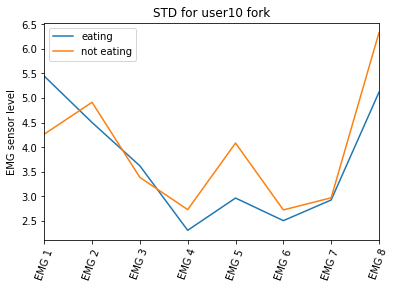

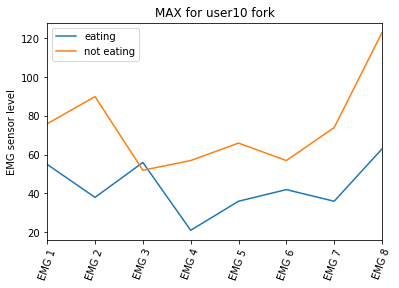

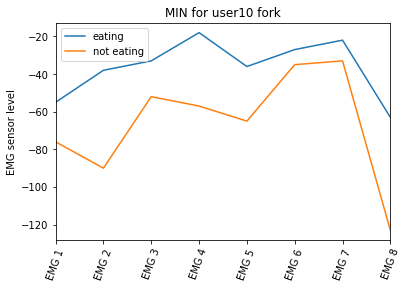

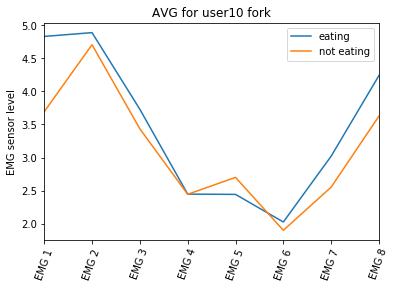

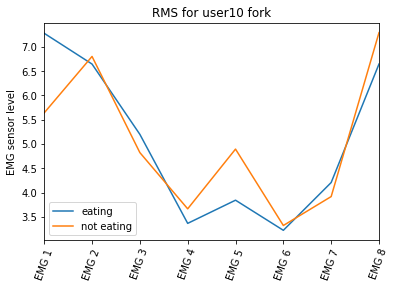

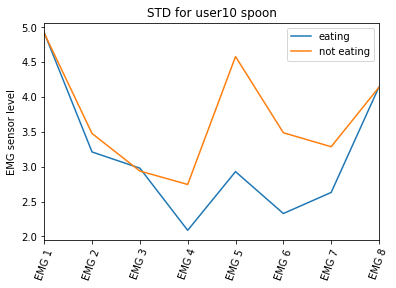

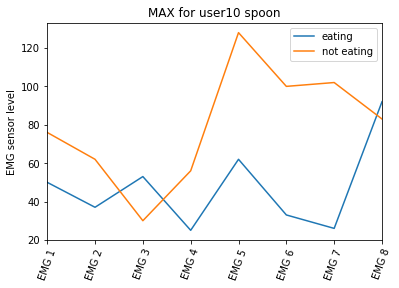

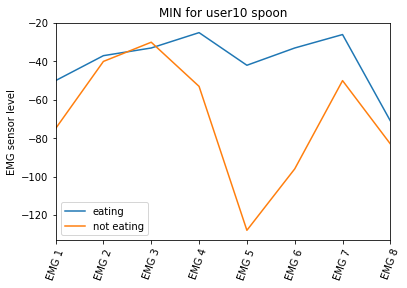

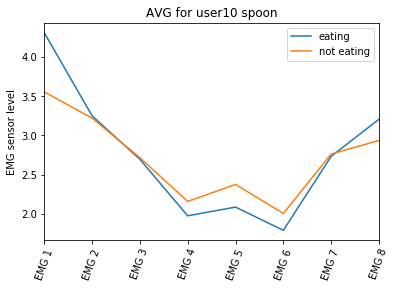

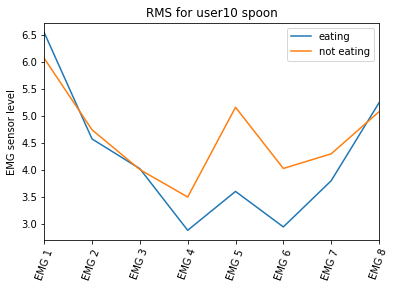

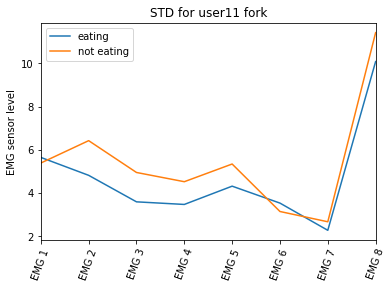

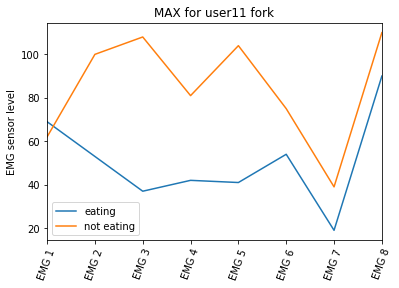

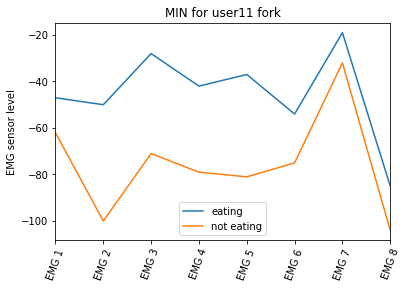

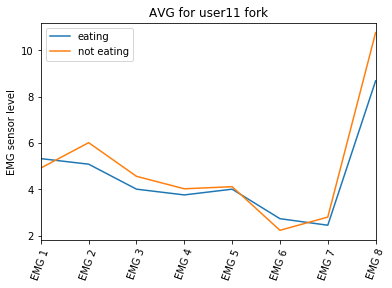

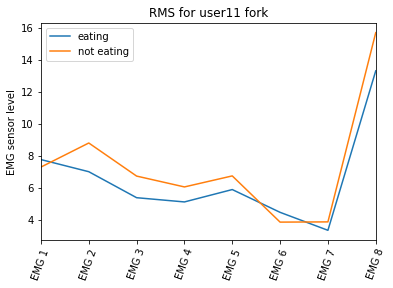

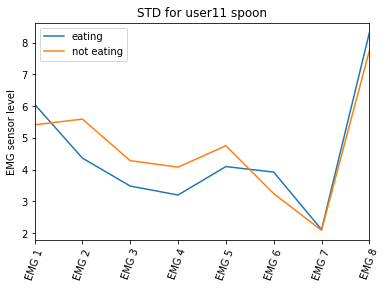

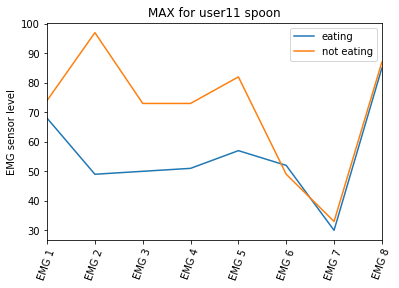

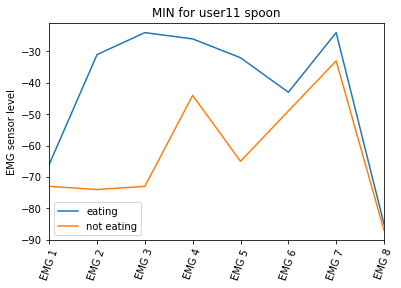

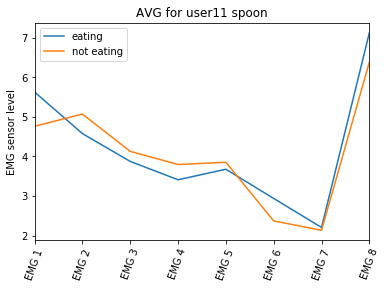

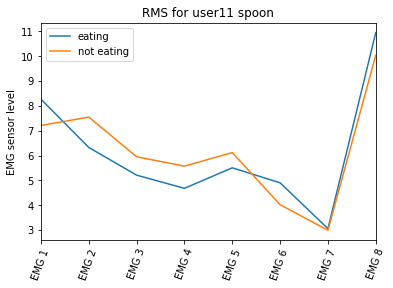

In [13]:
user_id = os.listdir("clean_data")
try:
    user_id.remove('.ipynb_checkpoints')
except:
    print(" ")
    
directory_graphs = "graphs/"
if not os.path.exists(directory_graphs):
    os.makedirs(directory_graphs)
    
for feature_user in ['user10','user11']:
    for item in ['fork','spoon']:
        
# feature_user = 'user12'
# item = 'spoon'
        df1 = get_clean_df(user=feature_user, fork_or_spoon=item, eating=True)
        df2 = get_clean_df(user=feature_user, fork_or_spoon=item, eating=False)

        STD_feature_extraction(df1,df2,col_wise=True,user=feature_user,item=item)
        MAX_feature_extraction(df1,df2,col_wise=True,user=feature_user,item=item)
        MIN_feature_extraction(df1,df2,col_wise=True,user=feature_user,item=item)
        AVG_feature_extraction(df1,df2,col_wise=True,user=feature_user,item=item)
        RMS_feature_extraction(df1,df2,col_wise=True,user=feature_user,item=item)


# Phase Three: Feature Selection

## Subtask 1: Arranging the feature matrix

In [13]:
feature_df = pd.DataFrame()

for user in user_id:
    for item in ['fork','spoon']:

        df1 = get_clean_df(user=user, fork_or_spoon=item, eating=True)
        df2 = get_clean_df(user=user, fork_or_spoon=item, eating=False)
        #df1_IMU = get_clean_df(data_for="IMU",eating=True,user=user)
        #df2_IMU = get_clean_df(data_for="IMU",eating=False,user=user)

        (STD_eating_EMG, STD_non_eating_EMG) = STD_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (MAX_eating_EMG, MAX_non_eating_EMG) = MAX_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (MIN_eating_EMG, MIN_non_eating_EMG) = MIN_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (AVG_eating_EMG, AVG_non_eating_EMG) = AVG_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)
        (RMS_eating_EMG, RMS_non_eating_EMG) = RMS_feature_extraction(df1,df2,col_wise=True,user=user,get_feature_data=True)

        STD_eating_EMG.columns = [str(col) + ' ' + 'STD' for col in STD_eating_EMG.columns]
        MAX_eating_EMG.columns = [str(col) + ' ' + 'MAX' for col in MAX_eating_EMG.columns]
        MIN_eating_EMG.columns = [str(col) + ' ' + 'MIN' for col in MIN_eating_EMG.columns]
        AVG_eating_EMG.columns = [str(col) + ' ' + 'AVG' for col in AVG_eating_EMG.columns]
        RMS_eating_EMG.columns = [str(col) + ' ' + 'RMS' for col in RMS_eating_EMG.columns]

        STD_non_eating_EMG.columns = [str(col) + ' ' + 'STD' for col in STD_non_eating_EMG.columns]
        MAX_non_eating_EMG.columns = [str(col) + ' ' + 'MAX' for col in MAX_non_eating_EMG.columns]
        MIN_non_eating_EMG.columns = [str(col) + ' ' + 'MIN' for col in MIN_non_eating_EMG.columns]
        AVG_non_eating_EMG.columns = [str(col) + ' ' + 'AVG' for col in AVG_non_eating_EMG.columns]
        RMS_non_eating_EMG.columns = [str(col) + ' ' + 'RMS' for col in RMS_non_eating_EMG.columns]

        #feature_df = STD_eating_EMG.append(MAX_eating_EMG)

        # feature_df = (STD_eating_EMG
        #     .append(MAX_eating_EMG)
        #     .append(MIN_eating_EMG)
        #     .append( AVG_eating_EMG)
        #     .append(RMS_eating_EMG)
        #     )
        eating_row = (STD_eating_EMG
                      .join(MAX_eating_EMG)
                      .join(MIN_eating_EMG)
                      .join(AVG_eating_EMG)
                      .join(RMS_eating_EMG)
                     )
        eating_row['eating'] = True
        feature_df = feature_df.append(eating_row,ignore_index=True)

        non_eating_row = (STD_non_eating_EMG
                      .join(MAX_non_eating_EMG)
                      .join(MIN_non_eating_EMG)
                      .join(AVG_non_eating_EMG)
                      .join(RMS_non_eating_EMG)
                     )
        non_eating_row['eating'] = False
        feature_df = feature_df.append(non_eating_row,ignore_index=True)
    
    

In [14]:
print("printing feature matrix with class labels added on. ")
print(feature_df)
feature_df
#feature_df

printing feature matrix with class labels added on. 
     EMG 1 STD  EMG 2 STD  EMG 3 STD  EMG 4 STD  EMG 5 STD  EMG 6 STD  \
0     9.994764   6.348598   2.346783   2.800840   1.199264   1.655630   
1     9.862380   7.951125   3.234015   4.346334   6.678731   4.920783   
2    12.463412   7.045510   2.868366   3.232639   3.029761   2.151716   
3     9.559006   7.453972   3.301232   3.369142   7.218943   4.461043   
4     5.444561   4.502032   3.621656   2.311489   2.967122   2.507739   
..         ...        ...        ...        ...        ...        ...   
115   7.721375   6.493706   3.473597   3.454244   3.716942   2.764415   
116   5.159439   7.002206   4.548621   3.459927   5.603252   2.744008   
117   4.354958   7.997612   4.879293   3.341963   5.289204   3.225389   
118   5.407013   6.323533   4.708486   4.387571   5.386242   2.325930   
119   4.968171   7.761984   5.697524   4.908618   5.883780   3.564194   

     EMG 7 STD  EMG 8 STD  EMG 1 MAX  EMG 2 MAX  ...  EMG 8 AVG  EMG 1

,EMG 1 STD,EMG 2 STD,EMG 3 STD,EMG 4 STD,EMG 5 STD,EMG 6 STD,EMG 7 STD,EMG 8 STD,EMG 1 MAX,EMG 2 MAX,...,EMG 8 AVG,EMG 1 RMS,EMG 2 RMS,EMG 3 RMS,EMG 4 RMS,EMG 5 RMS,EMG 6 RMS,EMG 7 RMS,EMG 8 RMS,eating
0,9.994764,6.348598,2.346783,2.800840,1.199264,1.655630,2.646408,6.218518,106,70,...,4.319406,13.732284,8.880713,3.456168,3.264523,1.724659,2.202381,3.513392,7.570593,True
1,9.862380,7.951125,3.234015,4.346334,6.678731,4.920783,2.442946,7.134351,84,77,...,5.206492,13.832874,10.776932,4.686439,4.977123,7.102058,5.515235,3.315531,8.831135,False
2,12.463412,7.045510,2.868366,3.232639,3.029761,2.151716,2.432998,9.007027,117,88,...,5.922704,17.142035,9.559754,4.055802,3.814031,3.531309,2.705680,3.157529,10.778699,True
3,9.559006,7.453972,3.301232,3.369142,7.218943,4.461043,2.036805,5.093179,93,121,...,3.774780,13.747165,9.938199,4.519333,3.871379,7.570243,4.791690,2.711108,6.338893,False
4,5.444561,4.502032,3.621656,2.311489,2.967122,2.507739,2.927570,5.117272,55,38,...,4.241098,7.278428,6.645336,5.198460,3.365987,3.843083,3.223154,4.206555,6.645819,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,7.721375,6.493706,3.473597,3.454244,3.716942,2.764415,2.696301,8.798157,112,117,...,4.417722,9.528529,8.122858,4.407990,4.094492,4.214429,3.283848,3.456286,9.843482,False
116,5.159439,7.002206,4.548621,3.459927,5.603252,2.744008,2.988274,4.905400,94,110,...,4.225913,6.475886,9.320144,6.312331,4.906532,7.068928,3.449095,3.873424,6.474454,True
117,4.354958,7.997612,4.879293,3.341963,5.289204,3.225389,3.056733,5.030867,60,92,...,4.466045,5.564208,10.354050,6.554367,4.654506,6.641964,3.752298,3.797035,6.726983,False
118,5.407013,6.323533,4.708486,4.387571,5.386242,2.325930,3.393585,4.905118,83,65,...,4.010718,6.679269,8.452811,6.480857,6.075806,6.961470,2.947313,4.301017,6.335773,True


## Subtask 2: Execution of PCA

In [15]:
def spider_plot(eigenvector, i=0):
    # Libraries
    from math import pi
    # Set data
    spider_df = feature_df.iloc[:,:-1]

    # number of variable
    categories=list(spider_df)[:]
    N = len(categories)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    # this will plot just the first eigenvector
    values=eigenvector.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig = plt.figure(figsize=(10,10))

    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    # plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    # plt.ylim(0,40)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title("eigenvector (or PC) " + str(i + 1))
    plt.savefig('graphs/123spiderPlot' + str(i+1) +'.png' , bbox_inches='tight')
    plt.show()

Top 5 eigenvalues:


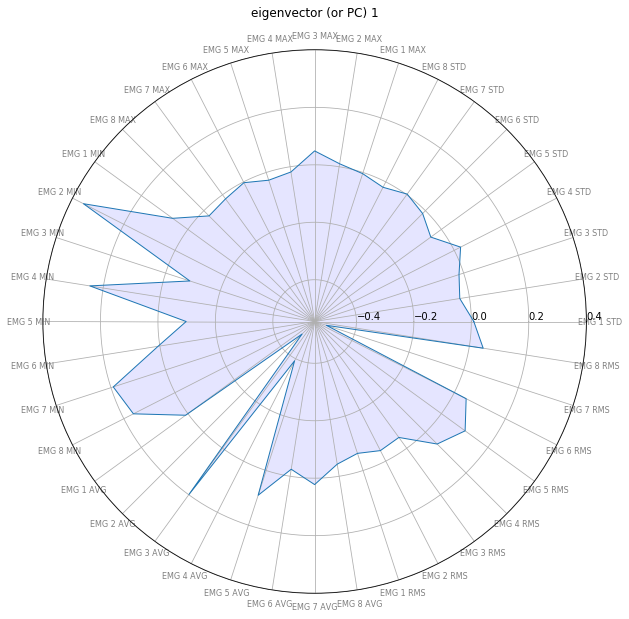

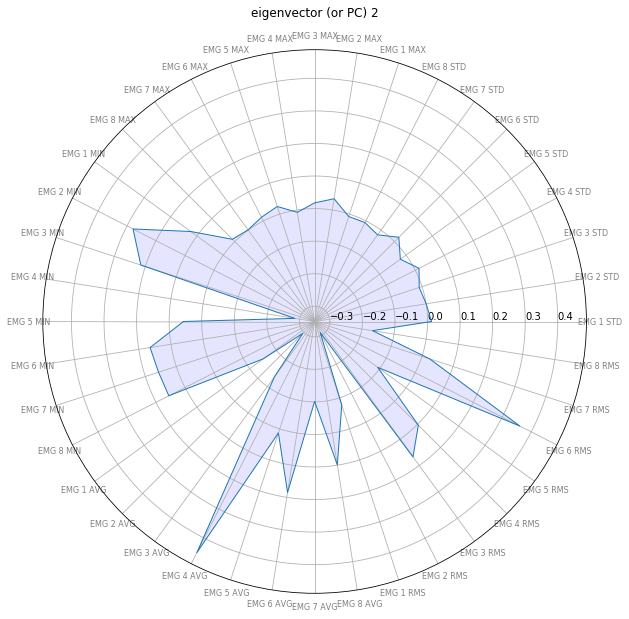

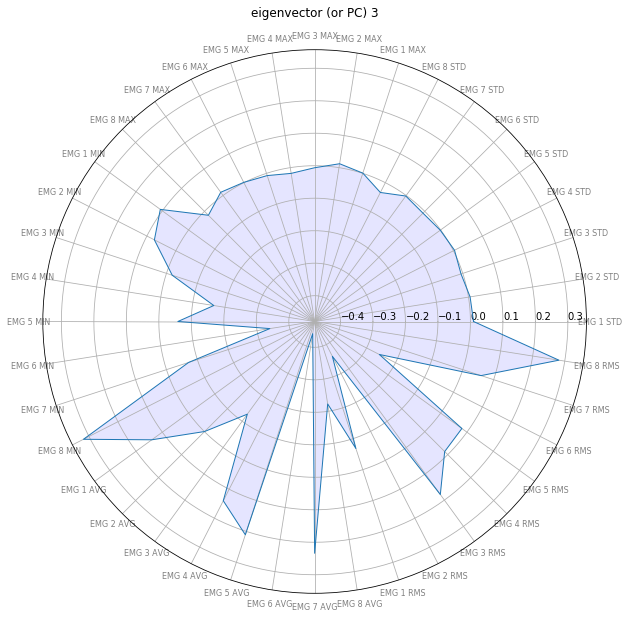

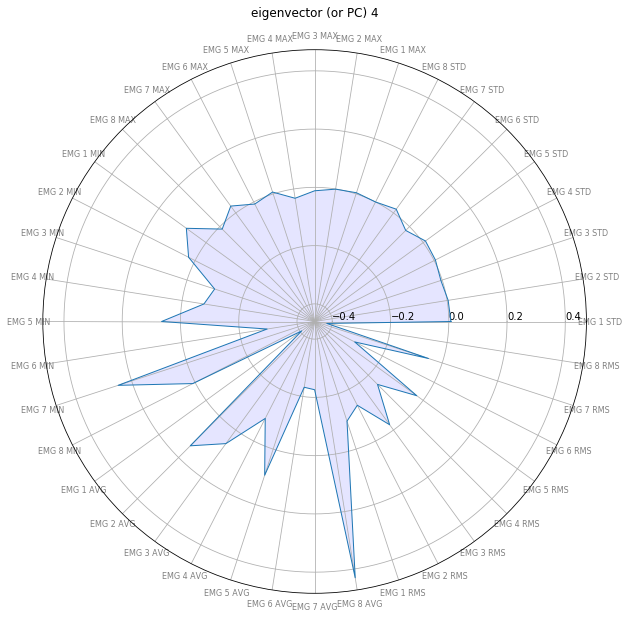

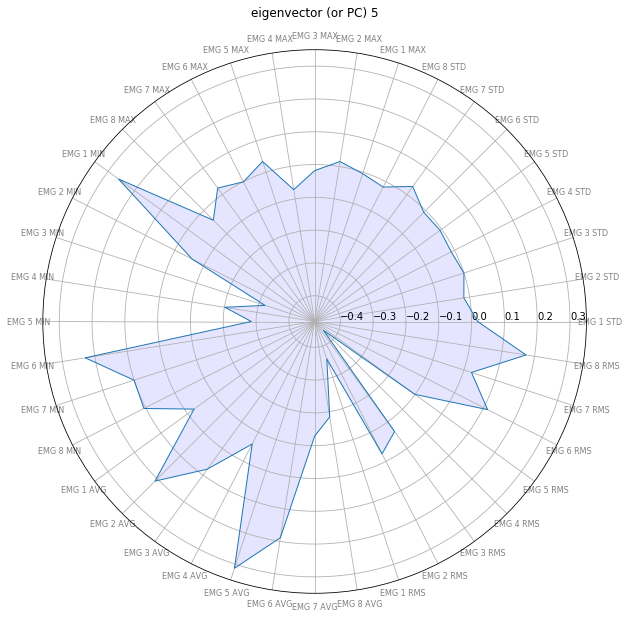

[9623.28533134 1389.68086567 1245.09731998  910.39574995  770.25556408]


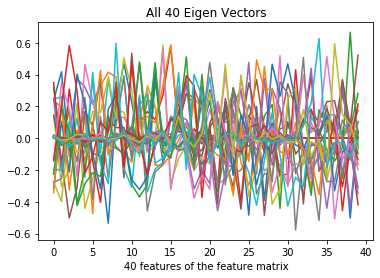

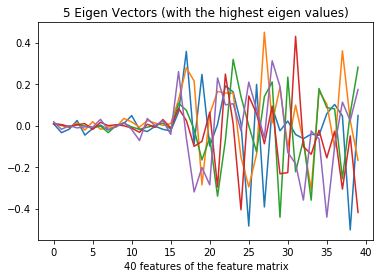

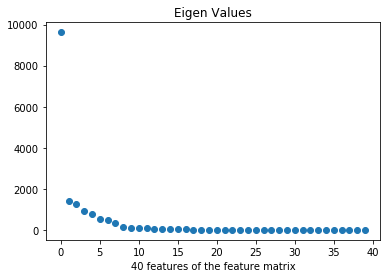

In [16]:
# a lot of this code is based on a tutorial at: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = feature_df.iloc[:,:-1]
X_std = StandardScaler().fit_transform(feature_df.iloc[:,:-1])

#pca = PCA(n_components=2)
pca = PCA()
# Y = pca.fit_transform(X_std)
Y = pca.fit_transform(X)

#cov_mat = np.cov(X_std.T)
#eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
eigen_values = pca.explained_variance_
eigen_vectors = pca.components_

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

    
print("Top 5 eigenvalues:")
for i in range(5):
    spider_plot(eig_pairs[i][1], i)
print(eigen_values[0:5])
plt.plot(eigen_vectors)
plt.title("All 40 Eigen Vectors")
plt.xlabel("40 features of the feature matrix")
plt.savefig('graphs/ALLeigenVectors.png' , bbox_inches='tight')
plt.show()
for i in range(5):
    plt.plot(eig_pairs[i][1])
plt.title("5 Eigen Vectors (with the highest eigen values)")
plt.xlabel("40 features of the feature matrix")
plt.savefig('graphs/5eigenVectors.png' , bbox_inches='tight')
plt.show()
plt.scatter(range(len(eigen_values)),eigen_values)
plt.title("Eigen Values")
plt.savefig('graphs/ALLeigenValues.png' , bbox_inches='tight')
plt.xlabel("40 features of the feature matrix")
plt.show()

# Subtask 3: Make sense of the PCA eigen vectors 

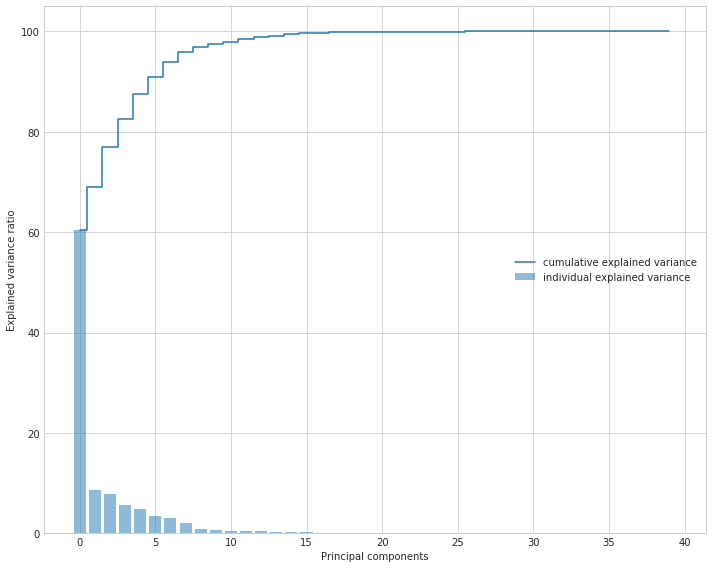

In [17]:
tot = sum(eigen_values)
var_exp = [(i / tot)*100 for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 8))

    plt.bar(range(40), var_exp, alpha=0.5, align='center',label='individual explained variance')
    plt.step(range(40), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.savefig('graphs/123explained_variance.png' , bbox_inches='tight')
    plt.show()

In [18]:
# here we can take the first principle component or the eigenvector with the highest eigenvalue and we can sort the weights and 
# use a background_gradient to see which sensors have the greatest weights. This lets us know which sensors are more important than others.
# when we make the projection matrix and multiply by the original feature space, the small weights mean that the sensor value will have little effect
# on the resulting projection matrix or new feature space.
sorted_eigen_vectors = []
for eigen_tuple in eig_pairs:
    sorted_eigen_vectors.append(eigen_tuple[1])

eigen_vectors_df = pd.DataFrame(sorted_eigen_vectors)
eigen_vectors_df.columns = (feature_df.iloc[:,:-1]).columns
first = eigen_vectors_df.iloc[0].sort_values(ascending=False)
print("printing first principle component with features ordered according to weight")
print(pd.DataFrame(first))
pd.DataFrame(first).style.background_gradient()
#display(HTML(pd.DataFrame(first).style.background_gradient().render()))

printing first principle component with features ordered according to weight
                  0
EMG 2 MIN  0.357696
EMG 4 MIN  0.246837
EMG 3 AVG  0.198690
EMG 7 MIN  0.191508
EMG 8 MIN  0.162504
EMG 5 RMS  0.102119
EMG 5 AVG  0.090562
EMG 1 MIN  0.065597
EMG 4 RMS  0.057704
EMG 8 RMS  0.048605
EMG 3 MAX  0.048405
EMG 6 RMS  0.046507
EMG 4 STD  0.024829
EMG 7 AVG  0.022246
EMG 2 MAX  0.010409
EMG 1 AVG  0.009684
EMG 1 STD  0.008593
EMG 6 MIN  0.006360
EMG 7 STD  0.002758
EMG 6 MAX -0.003174
EMG 1 MAX -0.004293
EMG 6 STD -0.013787
EMG 3 STD -0.016952
EMG 7 MAX -0.017813
EMG 4 MAX -0.018446
EMG 8 STD -0.021093
EMG 6 AVG -0.024729
EMG 8 MAX -0.025558
EMG 5 MAX -0.028300
EMG 2 STD -0.033897
EMG 2 RMS -0.041085
EMG 8 AVG -0.042629
EMG 5 STD -0.045596
EMG 3 RMS -0.046574
EMG 1 RMS -0.062781
EMG 3 MIN -0.088862
EMG 5 MIN -0.098304
EMG 4 AVG -0.391743
EMG 2 AVG -0.483694
EMG 7 RMS -0.502493


,0
EMG 2 MIN,0.357696
EMG 4 MIN,0.246837
EMG 3 AVG,0.19869
EMG 7 MIN,0.191508
EMG 8 MIN,0.162504
EMG 5 RMS,0.102119
EMG 5 AVG,0.0905619
EMG 1 MIN,0.0655967
EMG 4 RMS,0.0577042
EMG 8 RMS,0.0486049


In [19]:
# here I listed just the first five principle components and used the background gradient to help show that darker colors
# correspond to heavy or more important weights, and lighter colors are less important wieghts. 
first = eigen_vectors_df.iloc[0:5]#.sort_values(ascending=False)
print("printing the first few rows of the projection matrix. This shows the weights of each principle component")
print(first)

pd.DataFrame(first).style.background_gradient()
#display(HTML(pd.DataFrame(first).style.background_gradient().render()))

printing the first few rows of the projection matrix. This shows the weights of each principle component
   EMG 1 STD  EMG 2 STD  EMG 3 STD  EMG 4 STD  EMG 5 STD  EMG 6 STD  \
0   0.008593  -0.033897  -0.016952   0.024829  -0.045596  -0.013787   
1   0.012184   0.000114  -0.009131   0.012995  -0.021399   0.019009   
2   0.009660   0.005013  -0.005685   0.003717  -0.001430  -0.007859   
3   0.007306   0.003590  -0.004759   0.004794   0.009750  -0.018425   
4   0.018562  -0.017886   0.000065  -0.010892  -0.005766  -0.007964   

   EMG 7 STD  EMG 8 STD  EMG 1 MAX  EMG 2 MAX  ...  EMG 7 AVG  EMG 8 AVG  \
0   0.002758  -0.021093  -0.004293   0.010409  ...   0.022246  -0.042629   
1  -0.017817  -0.006009  -0.007747   0.034918  ...  -0.101378   0.099058   
2  -0.002132  -0.033792   0.000681   0.012135  ...   0.233887  -0.222519   
3   0.016089  -0.000055   0.004166  -0.000544  ...  -0.226338   0.430115   
4   0.030227  -0.018411  -0.004575   0.015256  ...  -0.128934  -0.184029   

   EMG 1 RM

,EMG 1 STD,EMG 2 STD,EMG 3 STD,EMG 4 STD,EMG 5 STD,EMG 6 STD,EMG 7 STD,EMG 8 STD,EMG 1 MAX,EMG 2 MAX,EMG 3 MAX,EMG 4 MAX,EMG 5 MAX,EMG 6 MAX,EMG 7 MAX,EMG 8 MAX,EMG 1 MIN,EMG 2 MIN,EMG 3 MIN,EMG 4 MIN,EMG 5 MIN,EMG 6 MIN,EMG 7 MIN,EMG 8 MIN,EMG 1 AVG,EMG 2 AVG,EMG 3 AVG,EMG 4 AVG,EMG 5 AVG,EMG 6 AVG,EMG 7 AVG,EMG 8 AVG,EMG 1 RMS,EMG 2 RMS,EMG 3 RMS,EMG 4 RMS,EMG 5 RMS,EMG 6 RMS,EMG 7 RMS,EMG 8 RMS
0,0.00859271,-0.0338971,-0.0169518,0.0248285,-0.0455956,-0.0137868,0.00275835,-0.0210934,-0.0042929,0.0104089,0.0484045,-0.0184461,-0.0282997,-0.00317425,-0.0178132,-0.0255575,0.0655967,0.357696,-0.0888619,0.246837,-0.0983035,0.00635957,0.191508,0.162504,0.0096837,-0.483694,0.19869,-0.391743,0.0905619,-0.0247287,0.0222465,-0.0426293,-0.0627814,-0.0410853,-0.0465744,0.0577042,0.102119,0.0465072,-0.502493,0.0486049
1,0.0121836,0.000114499,-0.0091313,0.0129948,-0.0213994,0.0190094,-0.0178167,-0.00600904,-0.00774742,0.0349178,0.0175596,-0.00724447,0.0245255,0.0125784,0.00113248,0.0102896,0.12342,0.279124,0.214508,-0.285356,0.0560011,0.164846,0.157283,0.155859,-0.151764,-0.295221,-0.137162,0.45005,0.0131567,0.184717,-0.101378,0.0990578,-0.0771275,-0.308903,0.167163,0.10362,-0.107316,0.360621,0.0248984,-0.166826
2,0.00965961,0.00501287,-0.00568477,0.00371694,-0.00143011,-0.00785944,-0.00213224,-0.0337922,0.000680697,0.0121353,-0.00623278,-0.0179195,-0.00727785,0.00110243,0.0121404,-0.0170592,0.107588,0.0740304,-0.0186242,-0.165271,-0.0585603,-0.339976,-0.0716484,0.319084,0.139959,-0.000637561,-0.126897,0.13978,0.21074,-0.441511,0.233887,-0.222519,-0.0685086,-0.359206,0.178751,0.0866128,0.0807692,-0.256048,0.0593635,0.281728
3,0.00730607,0.00358996,-0.00475895,0.00479414,0.00975025,-0.0184253,0.0160889,-5.45271e-05,0.00416633,-0.000544101,-0.0118208,-0.0322061,0.00668298,-0.0079868,0.0292388,-0.0118895,0.0837445,0.0249843,-0.0996012,-0.0758186,0.0648752,-0.295476,0.248549,0.00873912,-0.405506,0.14297,0.0575848,-0.0871188,0.0943572,-0.231984,-0.226338,0.430115,-0.100834,-0.137814,-0.0224071,-0.155137,-0.0271556,-0.306122,-0.0495688,-0.41816
4,0.0185621,-0.0178858,6.51503e-05,-0.0108916,-0.00576604,-0.00796423,0.0302271,-0.0184112,-0.00457466,0.0152559,-0.0186653,-0.0715688,0.0344002,-0.000589543,0.0243041,-0.0418797,0.26007,-0.0595626,-0.31956,-0.201493,-0.285436,0.229664,0.100257,0.105467,-0.024175,0.209551,0.0779207,-0.0593679,0.312401,0.188797,-0.128934,-0.184029,-0.358502,-0.0256157,-0.0639239,-0.440833,-0.100532,0.113462,0.0242664,0.174151


In [20]:
#first.iloc[0:1].sort_values(0,axis='columns',ascending=False).columns
#pd.DataFrame(eigen_vectors_df.iloc[0:5]).sort_values(0,axis='columns',ascending=False)#.style.background_gradient()
columns_list = first.columns.tolist()
#points_total = dict.fromkeys(columns_list)
points_total = dict([(col, 0) for col in columns_list])

for i in range(first.shape[0]):
    penalty = 0
    for col in first.iloc[i:i+1].sort_values(i,axis='columns',ascending=False).columns:
        points_total[col] += penalty
        penalty +=1

print("Generating the top five modified features")
print("\tUsing python dictionary to count which columns were the highest ranked in the top five PC's")
#points_total
sorted(points_total, key=points_total.get, reverse=False)[:5]

Generating the top five modified features
	Using python dictionary to count which columns were the highest ranked in the top five PC's


['EMG 1 MIN', 'EMG 8 MIN', 'EMG 5 AVG', 'EMG 2 MIN', 'EMG 7 MIN']

# Subtask 4: Results of PCA

In [28]:
# the new feature matrix is made by performing the dot product between the projection matrix W 
# ( which is the matrix containing the top k eigenvectors with the hightest eigenvalues)
# We are going to use the top 5 eigenvectors (or principle components) because with 5 you can see
# about 80% of the data
# so we take the projection matrix, and we take the dot product with the original feature matrix to obtain the new feature matrix or new feature space
# sklearn has a built in PCA function which will perform this operation for us

pca_5 = PCA(n_components=5)
#Y_5 = pca_5.fit_transform(X_std)
Y_5 = pca_5.fit_transform(X)
new_feature_space = pd.DataFrame(Y_5)
print("printing new feature space")
print(new_feature_space)
new_feature_space

printing new feature space
              0          1          2          3          4
0   -102.304742 -12.372565 -34.644204  50.015042 -32.254139
1     -0.300128 -27.901031  56.333862 -39.379301 -33.609012
2    -52.577516 -27.056992 -48.182003  22.093784 -51.514085
3     53.575709 -21.228938  17.985238 -40.431404 -27.784372
4   -121.323946   2.291399  18.295970   5.474396  16.765091
..          ...        ...        ...        ...        ...
115   -1.422306  -5.208647 -67.556772 -15.107284  -5.511506
116  -10.993742  16.582681 -10.961767  16.044141 -45.217387
117   69.792213  22.460840  19.915777  -6.082213  37.951157
118  -58.173591  35.547185  18.917284  22.436761  -4.835705
119  105.686347  52.967244  -0.929815 -41.773161  14.905060

[120 rows x 5 columns]


,0,1,2,3,4
0,-102.304742,-12.372565,-34.644204,50.015042,-32.254139
1,-0.300128,-27.901031,56.333862,-39.379301,-33.609012
2,-52.577516,-27.056992,-48.182003,22.093784,-51.514085
3,53.575709,-21.228938,17.985238,-40.431404,-27.784372
4,-121.323946,2.291399,18.295970,5.474396,16.765091
...,...,...,...,...,...
115,-1.422306,-5.208647,-67.556772,-15.107284,-5.511506
116,-10.993742,16.582681,-10.961767,16.044141,-45.217387
117,69.792213,22.460840,19.915777,-6.082213,37.951157
118,-58.173591,35.547185,18.917284,22.436761,-4.835705


In [33]:
a = feature_df.iloc[:,-1]
b = new_feature_space
b['eating'] = a
project2_df_file_name = 'new_feature_space.csv'
b.to_csv(project2_df_file_name, index=False)

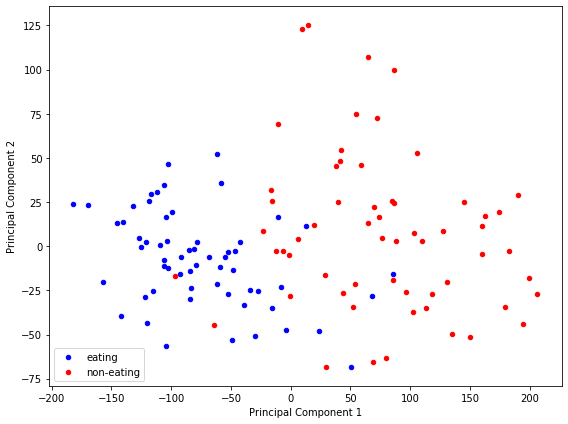

In [22]:
# To help understand the new feature matrix. We can look at the projection of data points onto PC 1, 2, and 3
# These plots below help show how the variance in the data is greastest for PC 1, then 2, then 3 etc
# these plots will be explained in the paper
class_label = feature_df.iloc[:,-1]
plt.figure(figsize=(8, 6))
for value, color, class_name in zip((True,False),
                               ('blue','red'),
                               ('eating','non-eating')):
    plt.scatter(Y[class_label == value, 0],
                Y[class_label == value, 1],
                label = class_name,
                c = color,
                s = 20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('graphs/2D.png' , bbox_inches='tight')
plt.show()

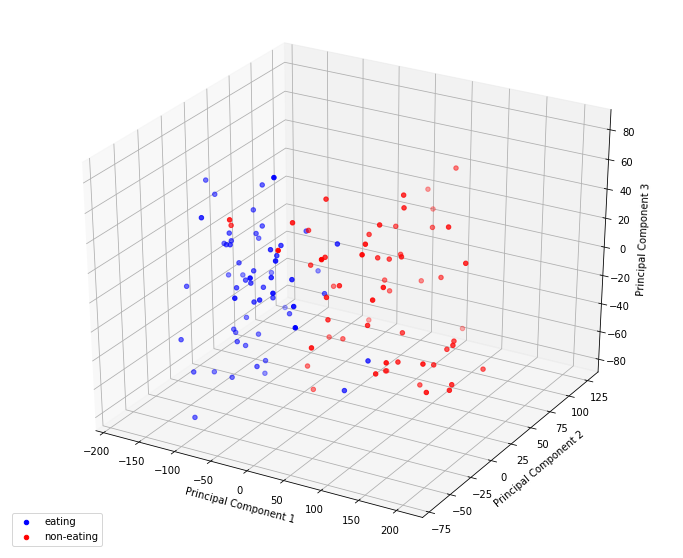

In [23]:
from mpl_toolkits.mplot3d import Axes3D
#sklearn_pca = sklearnPCA(n_components=3)
#Y_sklearn = sklearn_pca.fit_transform(X_std)

fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111, projection='3d')

for value, color, class_name in zip((True,False),
                        ('blue','red'),
                        ('eating','non-eating')):
        ax.scatter(Y[class_label == value, 0],
                   Y[class_label == value, 1],
                   Y[class_label == value, 2],
                   label = class_name,
                   c = color)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend(loc='lower left')
plt.savefig('graphs/3D.png' , bbox_inches='tight')
plt.show()

# Subtask 5: Argue whether doing PCA was helpful or not

In [24]:
# this will be discussed in the paper